In [24]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

In [4]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1800) #5 years analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["VOO"]

tickers = final_ticker(SnP_componet_ticker)

def get_stock_data(tickers_list, start_date, end_date=None):
    
    all_tickers = list(dict.fromkeys(tickers_list))
    
    data = yf.download(all_tickers, start=start_date, end=end_date)['Close']
    if isinstance(data, pd.DataFrame):
        data = data.dropna(axis=1)
        available_tickers = list(data.columns)
    else:
        available_tickers = all_tickers
    
    return data, available_tickers

def initialize_portfolio(tickers, equal_weight=True):
    n_assets = len(tickers)
    if equal_weight:
        weight = 1.0/n_assets
    else:
        weight = 1.0
        
    return {ticker: weight for ticker in tickers}

df,tickers = get_stock_data(tickers,valid_start_day)

df_BM,_ = get_stock_data(index_banch_mart, valid_start_day)
number_of_stocks = df.shape[1]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B', 'ETR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-03-19 -> 2025-02-21)')
[*********************100%***********************]  1 of 1 completed


In [5]:
def Get_rfr(start):
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', start).dropna()
        shifted_date += 1
    return risk_free_rate/100
rfr = Get_rfr(valid_start_day)

In [18]:
SnP_sector_ETF_tickers = [
    "XLC",  # Communication Services
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Health Care
    "XLI",  # Industrials
    "XLK",  # Technology
    "XLB",  # Materials
    "XLRE", # Real Estate
    "XLU"   # Utilities
]
SnP_sector_ETF_tickers = final_ticker(SnP_sector_ETF_tickers)

df_sector_etfs,tickers_ETFs = get_stock_data(SnP_sector_ETF_tickers,valid_start_day)

[*********************100%***********************]  11 of 11 completed


## Previous strategy

Decompose SnP500 into principle componet, then pick the top 5 component that has the highest sharp ratio, hold for a month.

## New strategy
1) Decompose SnP500 into principle componet
2) Pick the top 5 principle components with highest sharp ratio
3) Do linear regression for the PCs and the SnP sector ETF, re-map everything into these ETF(Lower borrowing cost, management cost, etc)
4) Update every month, past window = 252 days, holding period = 21 days

In [127]:
def calculate_returns(df, df_sector_etfs, rfr):
    """Calculate log returns for data and align risk-free rate"""
    ret_df = np.log(df/df.shift(1)).dropna()
    ret_sector = np.log(df_sector_etfs/df_sector_etfs.shift(1)).dropna()
    rfr_aligned = rfr.reindex(ret_df.index, method='ffill')
    return ret_df, ret_sector, rfr_aligned

def calculate_pc_performance(window_data, loadings, window_rfr):
    """Calculate performance metrics and Sharpe ratio for each PC"""
    pc_performance = pd.DataFrame(index=loadings.columns)
    
    for pc in loadings.columns:
        pc_returns = (window_data @ loadings[pc])
        simple_returns = np.exp(pc_returns) - 1
        annual_return = (1 + simple_returns.mean()) ** 252 - 1
        annual_vol = simple_returns.std() * np.sqrt(252)
        window_annual_rfr = window_rfr * 252

        # Add check for zero volatility
        if annual_vol == 0:
            pc_performance.loc[pc, 'Sharpe'] = 0
        else:
            pc_performance.loc[pc, 'Sharpe'] = (annual_return - window_annual_rfr) / annual_vol
    
    return pc_performance

def calculate_performance_metrics(returns, rfr):
    """Calculate performance metrics for a strategy"""
    # Handle different input types
    if isinstance(returns, (float, np.float64)):
        return {
            'returns': 0,
            'cum_returns': 1,
            'annual_return': 0,
            'annual_vol': 0,
            'sharpe': 0
        }
    
    # Convert to pandas Series if it's numpy array
    if isinstance(returns, np.ndarray):
        returns = pd.Series(returns)
    
    # Calculate simple returns from log returns
    try:
        simple_returns = pd.Series(np.exp(returns.values) - 1, index=returns.index)
    except:
        simple_returns = pd.Series(returns.values, index=returns.index)
    
    cum_returns = (1 + simple_returns).cumprod()
    
    # Calculate annualized metrics
    annual_return = (1 + simple_returns.mean()) ** 252 - 1
    annual_vol = simple_returns.std() * np.sqrt(252)
    
    # Handle zero volatility case
    if annual_vol == 0 or np.isnan(annual_vol):
        sharpe = 0
    else:
        sharpe = (annual_return - rfr) / annual_vol
    
    return {
        'returns': simple_returns,
        'cum_returns': cum_returns,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe
    }

def calculate_performance_metrics_simple(returns, rfr):
    """Calculate performance metrics for a strategy using simple returns"""
    if isinstance(returns, (float, np.float64)):
        return {
            'returns': 0,
            'cum_returns': 1,
            'annual_return': 0,
            'annual_vol': 0,
            'sharpe': 0
        }
    
    # Convert to pandas Series if it's numpy array
    if isinstance(returns, np.ndarray):
        returns = pd.Series(returns)
    
    cum_returns = (1 + returns).cumprod()
    
    # Calculate annualized metrics
    annual_return = (1 + returns.mean()) ** 252 - 1
    annual_vol = returns.std() * np.sqrt(252)
    
    # Handle zero volatility case
    if annual_vol == 0 or np.isnan(annual_vol):
        sharpe = 0
    else:
        sharpe = (annual_return - rfr) / annual_vol
    
    return {
        'returns': returns,
        'cum_returns': cum_returns,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe
    }

def calculate_sector_betas(pc_returns, sector_returns):
    """Calculate betas for each PC against sector ETFs using linear regression"""
    betas = pd.DataFrame(index=sector_returns.columns, columns=pc_returns.columns)
    
    # Standardize PC returns to prevent numerical issues
    pc_returns_std = pc_returns.apply(lambda x: (x - x.mean()) / x.std())
    sector_returns_std = sector_returns.apply(lambda x: (x - x.mean()) / x.std())
    
    for pc in pc_returns.columns:
        for sector in sector_returns.columns:
            try:
                model = LinearRegression()
                X = pc_returns_std[pc].values.reshape(-1, 1)
                y = sector_returns_std[sector].values
                model.fit(X, y)
                betas.loc[sector, pc] = model.coef_[0]
            except:
                betas.loc[sector, pc] = 0
                
    # Clip extreme values
    betas = betas.clip(-1, 1)
    
    return betas

def construct_portfolio(loadings, top_pcs, sector_betas):
    """Construct final portfolio using PC loadings and sector betas"""
    # First construct stock weights from PCs
    stock_weights = pd.Series(0.0, index=loadings.index)
    for pc in top_pcs:
        stock_weights += loadings[pc] / len(top_pcs)
    
    # Normalize stock weights
    if stock_weights.sum() != 0:
        stock_weights = stock_weights / stock_weights.sum()
    
    # Calculate sector weights as mean of standardized betas
    sector_weights = sector_betas[top_pcs].mean(axis=1)
    
    # Ensure weights sum to 1 and are reasonable
    if sector_weights.sum() != 0:
        sector_weights = sector_weights / abs(sector_weights.sum())
    
    return stock_weights, sector_weights

def plot_strategy_results(results):
    """Plot both strategy results along with benchmark"""
    fig, ax = plt.subplots(figsize=(15, 8))
    
    pc_perf = results['pc_performance']
    etf_perf = results['etf_performance']
    bm_perf = results['benchmark_performance']
    
    ax.plot(pc_perf['cum_returns'].index, pc_perf['cum_returns'], 
            label=f'PC Strategy (Sharpe: {pc_perf["sharpe"]:.2f})')
    ax.plot(etf_perf['cum_returns'].index, etf_perf['cum_returns'], 
            label=f'ETF Strategy (Sharpe: {etf_perf["sharpe"]:.2f})')
    ax.plot(bm_perf['cum_returns'].index, bm_perf['cum_returns'], 
            label=f'Benchmark (Sharpe: {bm_perf["sharpe"]:.2f})', linestyle='--')
    
    ax.set_title('PCA Strategy Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig, ax

def Market_metric(result):
    
    import Functions.AlphaBeta as MT
    
    pc_rt = results['pc_strategy_returns']
    etf_rt = results['etf_strategy_returns']
    bm_rt = results['benchmark_returns']
    
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.title('PCA')
    alpha, beta = MT.AlphaBeta(bm_rt,pc_rt,plot=True)
    print(f'PCA: Alpha = {alpha}, Beta = {beta}')
    PCA_Down_metric = MT.downside_metrics(pc_rt, bm_rt)
    print('PCA drawdown metric')
    for k in PCA_Down_metric:
        print(f'{k}: {PCA_Down_metric[k]}')

    fig, ax = plt.subplots(figsize=(15, 8))
    plt.title('ETF')
    alpha, beta = MT.AlphaBeta(bm_rt,etf_rt,plot=True)
    print(f'ETFs: Alpha = {alpha}, Beta = {beta}')
    ETF_Down_metric = MT.downside_metrics(etf_rt, bm_rt)
    print('ETF drawdown metric')
    for k in ETF_Down_metric:
        print(f'{k}: {ETF_Down_metric[k]:.3f}')



In [129]:
def rolling_pca_strategy(df, df_sector_etfs, rfr, df_BM, lookback_days=252, holding_days=21, n_components=5):
    """Main strategy function"""
    # Initialize and align all data
    ret_df, ret_sector, rfr_aligned = calculate_returns(df, df_sector_etfs, rfr)
    
    # Convert benchmark to Series if it's a DataFrame
    if isinstance(df_BM, pd.DataFrame):
        df_BM = df_BM.iloc[:, 0]
    
    # Align benchmark data with the same index
    df_BM = df_BM.reindex(df.index)
    ret_BM = pd.Series(np.log(df_BM/df_BM.shift(1)).dropna(), name='benchmark')
    
    # Initialize return series
    strategy_returns_pc = pd.Series(index=ret_df.index, dtype=float)     # Direct PC strategy
    strategy_returns_etf = pd.Series(index=ret_df.index, dtype=float)    # ETF-mapped strategy
    selected_pcs_history = []
    
    # Get all dates
    all_dates = ret_df.index.tolist()
    current_idx = 0
    
    while current_idx < len(all_dates):
        start_date = all_dates[current_idx]
        
        # Define the window
        lookback_start_idx = max(0, current_idx - lookback_days)
        window_data = ret_df.iloc[lookback_start_idx:current_idx]
        window_sector = ret_sector.iloc[lookback_start_idx:current_idx]
        
        if len(window_data) < 30:
            current_idx += holding_days
            continue
        
        window_rfr = rfr_aligned.loc[window_data.index].mean()
        if isinstance(window_rfr, pd.Series):
            window_rfr = window_rfr.iloc[0]
        window_rfr = window_rfr / 252
        
        # Perform PCA
        pca_results, loadings = perform_pca_analysis(window_data, n_components)
        
        # Calculate PC performance and select top PCs
        pc_performance = calculate_pc_performance(window_data, loadings, window_rfr)
        top_pcs = pc_performance.nlargest(n_components, 'Sharpe').index
        selected_pcs_history.append((start_date, top_pcs))
        
        # Calculate sector betas
        sector_betas = calculate_sector_betas(pca_results[top_pcs], window_sector)
        
        # Define holding period
        hold_end_idx = min(current_idx + holding_days, len(all_dates))
        hold_dates = all_dates[current_idx:hold_end_idx]
        
        if len(hold_dates) == 0:
            break
        
        # Calculate portfolio returns for both strategies
        holding_window = ret_df.loc[hold_dates]
        sector_holding_window = ret_sector.loc[hold_dates]
        
        # Strategy 1: Direct PC portfolio
        pc_weights = pd.Series(0.0, index=loadings.index)
        for pc in top_pcs:
            pc_weights += loadings[pc] / len(top_pcs)
        if pc_weights.sum() != 0:
            pc_weights = pc_weights / pc_weights.sum()
        
        # Strategy 2: ETF-mapped portfolio
        sector_weights = sector_betas[top_pcs].mean(axis=1)
        if sector_weights.sum() != 0:
            sector_weights = sector_weights / abs(sector_weights.sum())
        
        # Calculate returns for both strategies
        pc_portfolio_returns = (holding_window * pc_weights).sum(axis=1)
        etf_portfolio_returns = (sector_holding_window * sector_weights).sum(axis=1)
        
        # Assign values
        strategy_returns_pc.loc[hold_dates] = pc_portfolio_returns.astype(float)
        strategy_returns_etf.loc[hold_dates] = etf_portfolio_returns.astype(float)
        
        current_idx += holding_days
    
    # Convert log returns to simple returns
    simple_returns_pc = pd.Series(np.exp(strategy_returns_pc.dropna()) - 1)
    simple_returns_etf = pd.Series(np.exp(strategy_returns_etf.dropna()) - 1)
    simple_returns_bm = pd.Series(np.exp(ret_BM) - 1)
    
    # Align all return series
    common_dates = simple_returns_pc.index.intersection(
        simple_returns_etf.index.intersection(simple_returns_bm.index)
    )
    
    simple_returns_pc = simple_returns_pc.loc[common_dates]
    simple_returns_etf = simple_returns_etf.loc[common_dates]
    simple_returns_bm = simple_returns_bm.loc[common_dates]
    
    # Calculate performance metrics
    final_rfr = rfr_aligned.loc[common_dates].mean()
    if isinstance(final_rfr, pd.Series):
        final_rfr = final_rfr.iloc[0]
    
    pc_performance = calculate_performance_metrics_simple(simple_returns_pc, final_rfr)
    etf_performance = calculate_performance_metrics_simple(simple_returns_etf, final_rfr)
    bm_performance = calculate_performance_metrics_simple(simple_returns_bm, final_rfr)
    
    return {
        'pc_strategy_returns': simple_returns_pc,
        'etf_strategy_returns': simple_returns_etf,
        'benchmark_returns': simple_returns_bm,
        'selected_pcs_history': selected_pcs_history,
        'pc_performance': pc_performance,
        'etf_performance': etf_performance,
        'benchmark_performance': bm_performance
    }

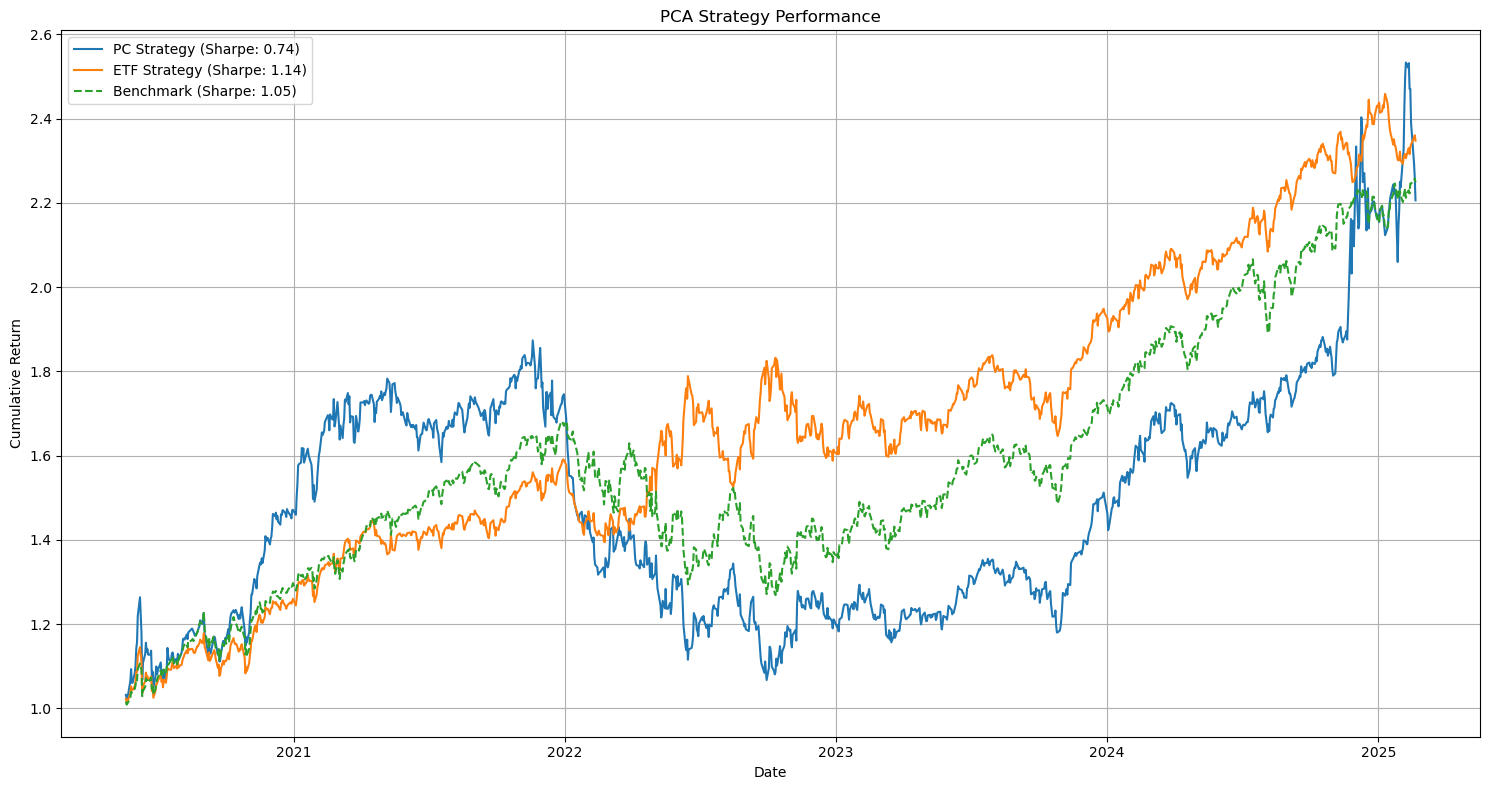

In [131]:
results = rolling_pca_strategy(df, df_sector_etfs, rfr,df_BM)
fig, ax = plot_strategy_results(results)
plt.show()

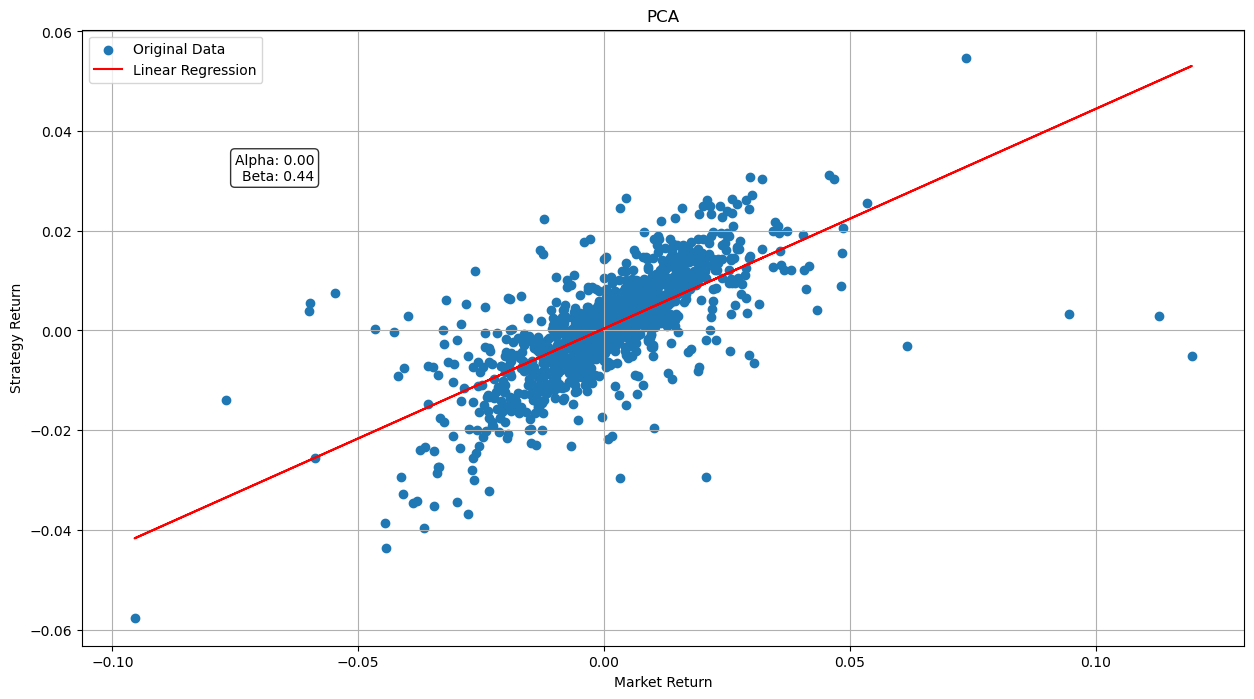

PCA: Alpha = 0.0, Beta = 0.441
PCA drawdown metric
max_drawdown: -0.43029269898266304
max_drawdown_duration: 728
var_95: -0.025273901908776764
cvar_95: -0.03623307314563633
down_beta: 1.0244324075599398


/Users/arnold/Coding/Portfolio_theory/Functions/AlphaBeta.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if drawdowns[i] < 0:
/Users/arnold/Coding/Portfolio_theory/Functions/AlphaBeta.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if drawdowns[i] == 0:


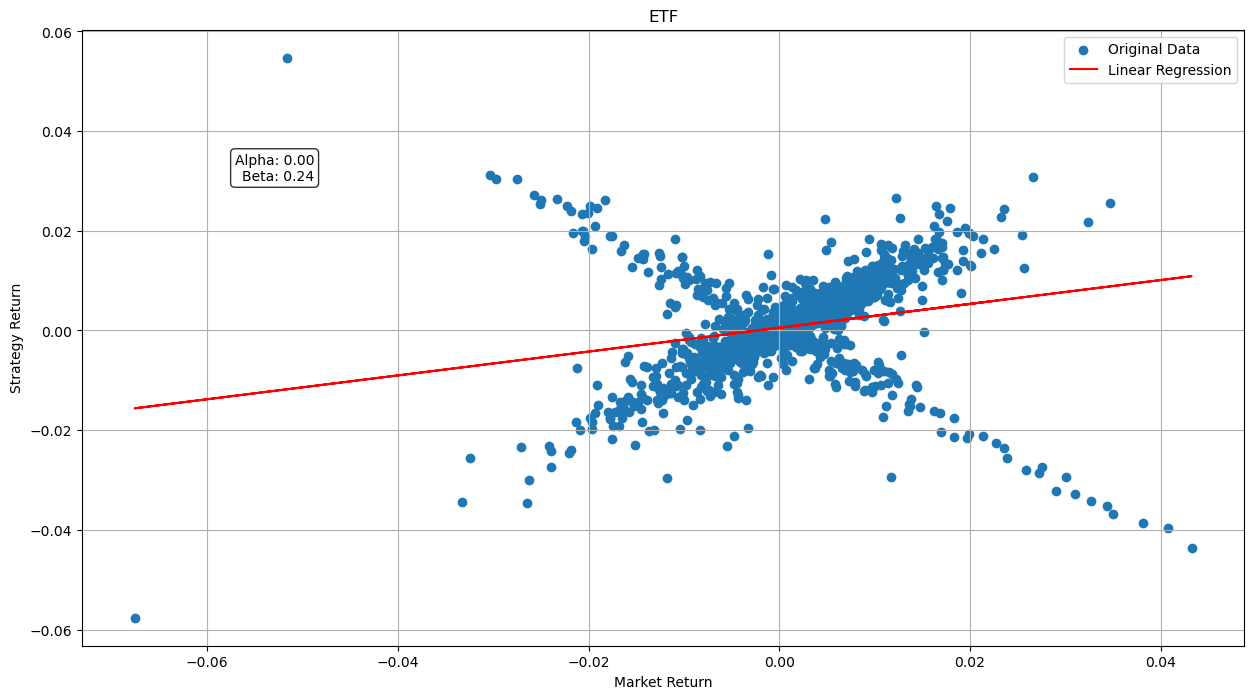

ETFs: Alpha = 0.001, Beta = 0.239
ETF drawdown metric
max_drawdown: -0.148
max_drawdown_duration: 194.000
var_95: -0.016
cvar_95: -0.022
down_beta: -0.025


In [132]:
Market_metric(results)